In [1]:
import json
import ROOT
from analysis_framework import WWAnalysis, ILDMC2020Dataset, Dataset

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x7006420


In [2]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad
n_threads = 12
prod = True
no_rvec = False
dataset_path = "data/datasets/miniDSTs/processed-test.json"
output_path = "root://eosproject.cern.ch//eos/experiment/clicdp/data/user/l/lreichen/snapshots/test"
output_meta = "test.json"
checked_output_meta = "checked-test.json"
output_collections = ["PandoraPFOs"]
plot_dir = "plots/pre-selection/test"
if prod:
    dataset_path = "data/datasets/miniDSTs/processed-no-exc-higgs.json"
    # dataset_path = "data/datasets/miniDSTs/processed-no-exc-higgs-reduced.json"
    # dataset_path = "data/datasets/miniDSTs/processed-no-exc-higgs-reduced500.json"
    output_path = "root://eosproject.cern.ch//eos/experiment/clicdp/data/user/l/lreichen/snapshots/full"
    output_meta = "full.json"
    checked_output_meta = "checked-full.json"
    output_collections = r"^(?!R2jet_lvecs)\w+$"
    plot_dir = "plots/pre-selection/full"


In [3]:
ROOT.EnableImplicitMT(n_threads)

In [4]:
dataset = Dataset.from_json(dataset_path)

In [5]:
analysis = WWAnalysis(dataset)

analysis.init_parameters([
    ("WWCategorisation.RecoCatBasic", "int", "8"),
    ("WWCategorisation.RecoCatAdvanced", "int", "8"),
    ("WWCategorisation.missE", "float", "-42"),
    ("WWCategorisation.misspT", "float", "-42"),
    ("WWCategorisation.mInv", "float", "-42"),
    ("Energy", "float", "-42"),
])

In [6]:
# signal cut goes here:
# In this case, we want to require the charged lepton in the final state to be inside of the detector acceptance
# just take the first gen status 1 particle with a fitting pdg value and cut on theta
lep_pdg = 11
# CLD 150 mrad
# ILD ~84 mrad (IDR: 4.8 deg)
acceptance_theta = 0.084
signal_cut = f"""
std::invoke([](auto& genStat, auto& pdg, auto& px, auto& py, auto& pz, auto& m) -> bool {{
auto lepton_mask = genStat == 1 && abs(pdg) == {lep_pdg};
// abuse ArgMax to get the first set position
auto lepton_idx = ArgMax(lepton_mask);
auto lepton_lvec = ROOT::Math::PxPyPzMVector(px[lepton_idx], py[lepton_idx],
                                             pz[lepton_idx], m[lepton_idx]);
double lepton_theta = lepton_lvec.Theta();
return abs(cos(lepton_theta)) < cos({acceptance_theta});
}}, MCParticlesSkimmed.generatorStatus, MCParticlesSkimmed.PDG, MCParticlesSkimmed.momentum.x, MCParticlesSkimmed.momentum.y, MCParticlesSkimmed.momentum.z, MCParticlesSkimmed.mass)
"""

In [7]:
analysis.set_categories({
    # TODO: actually implement the cut, but I might notice when refactoring the cut-flow...
    # "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": "1 == 1"},
    "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": signal_cut},
    "4f_sl_bkg": {"pattern": r"4f\w+sl", "cut": None }, # inverse signal cut will be applied automatically
    "4f_not_sl": {"pattern": r"4f\w+_(?:h|l)", "cut": None },
    # separate out aa_4f? super low lumi anyway
    "aa2f": {"pattern": "aa_2f", "cut": None},
    # 2f but not aa_2f
    "2f": {"pattern": "(?<!aa_)2f", "cut": None},
    "3f": {"pattern": "ea_3f|ae_3f", "cut": None},
    "5f": {"pattern": "ea_5f|ae_5f", "cut": None},
    "6f": {"pattern": "6f", "cut": None},
    # need to filter out anything ending in _h and 2f_z_eehiq
    "higgs": {"pattern": "[^_e]h", "cut": None},
})
# check if we missed any processes
print(analysis.is_complete_categorisation())

True


In [8]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
analysis.Define("n_isomuons", "IsolatedMuons_objIdx.size()")
analysis.Define("n_isoelectrons", "IsolatedElectrons_objIdx.size()")
analysis.Define("RecoCatBasic", "params_WWCategorisation_RecoCatBasic")
analysis.Define("RecoCatAdvanced", "params_WWCategorisation_RecoCatAdvanced")
analysis.Define("n_charged_PFOs", "Sum(abs(PandoraPFOs.charge) == 1.)")
analysis.Define("n_R2jets", "Refined2Jets.size()")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))
analysis.Define("M_jj", "ROOT::VecOps::Sum(R2jet_lvecs, ROOT::Math::PxPyPzEVector()).mass()")
analysis.Define("PVertex_ndf", "PrimaryVertex.ndf")
analysis.Define("PVertex_chi2", "PrimaryVertex.chi2")
analysis.Define("PVertex_chi2ndf", "PVertex_chi2 / PVertex_ndf")

analysis.define_reco_objects(x_angle)
analysis.remove_x_angle(x_angle)
analysis.Define("M_Wlep", "ub_leptonic_W_lvec.M()")
analysis.Define("M2_Wlep_sign", "M_Wlep / abs(M_Wlep)")

In [9]:
analysis.book_histogram_1D("RecoCatBasic", "RecoCatBasic", ("", ";RecoCatBasic", 8, 0., 8.))
# analysis.book_histogram_1D("RecoCatAdvanced", "RecoCatAdvanced", ("", ";RecoCatAdvanced", 8, 0., 8.))
# analysis.add_filter("RecoCatAdvanced == 2", "RecoCatAdvanced == 2")

In [10]:
analysis.book_histogram_1D("n_isoelectrons", "n_isoelectrons", ("", ";n_isoelectrons", 5, 0., 5.))
analysis.add_filter("n_isoelectrons == 1", "1 iso electron")

analysis.book_histogram_1D("n_charged_PFOs", "n_charged_PFOs", ("", ";n_charged_PFOs", 50, 0., 50.))
analysis.add_filter("n_charged_PFOs >= 10", "N_{#pm}#geq 10")

analysis.book_histogram_1D("misspT", "params_WWCategorisation_misspT", ("", ";misspT", 100, 0., 100.))
analysis.add_filter("params_WWCategorisation_misspT >= 10", "misspT#geq 10")

analysis.book_histogram_1D("RecoCatAdvanced", "RecoCatAdvanced", ("", ";RecoCatAdvanced", 8, 0., 8.))
analysis.add_filter("RecoCatAdvanced == 2", "RecoCat = 2")

analysis.book_histogram_1D("M2_Wlep_sign", "M2_Wlep_sign", ("", ";M2_Wlep_sign", 5, -1.5, 3.5))
analysis.add_filter("M2_Wlep_sign > 0", "M2_Wlep_sign > 0")

analysis.book_histogram_1D("PVertex_ndf", "PVertex_ndf", ("", ";PVertex_ndf", 50, 1., 101.))
analysis.book_histogram_1D("missE", "params_WWCategorisation_missE", ("", ";missE", 300, -50., 250.))
analysis.book_histogram_1D("mInv", "params_WWCategorisation_mInv", ("", ";mInv", 100, 40., 140.))
analysis.book_histogram_1D("M_jj", "M_jj", ("", ";M_jj", 100, 32., 132.))
analysis.book_histogram_1D("n_isomuons", "n_isomuons", ("", ";n_isomuons", 5, 0., 5.))
analysis.book_histogram_1D("PVertex_chi2", "PVertex_chi2", ("", ";PVertex_chi2", 75, 0., 150.))
analysis.book_histogram_1D("PVertex_chi2ndf", "PVertex_chi2ndf", ("", ";PVertex_chi2/ndf", 20, 0., 10.))

In [11]:
analysis.book_reports()

In [12]:
# analysis.book_snapshots("events", "data/snapshots", ["PandoraPFOs"])
# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test/reduced", ["PandoraPFOs"])
# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test/reduced500", ["PandoraPFOs"])
# Have also no dict for these RVecs thanks to root having forgotten it...
# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test-full/full-zstd-9", column_list=r"^(?!R2jet_lvecs)\w+$", no_rvec=True)

# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test/test", "data/datasets/snapshots/test.json", ["PandoraPFOs"])
# analysis.book_snapshots("events", "/home/lreichen/work/enuW/data/snapshots/pre-selected-full/full-zstd-9", "data/datasets/snapshots/full.json", ["PandoraPFOs"])
# analysis.book_snapshots("events", output_path, output_meta, output_collections, no_rvec=no_rvec)

In [13]:
%%time
analysis.run()

CPU times: user 21min 32s, sys: 3min 54s, total: 25min 27s
Wall time: 20min 21s
OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x35d1f970


In [ ]:
# analysis.check_snapshots("events", output_path, checked_output_meta)
nums, _ = analysis._calc_cutflow()
print(nums)
import numpy as np
for k, n in nums.items():
    print(k)
    print(np.format(np.asarray(n)))

{'4f_sw_sl_signal': [13144056.22825978, 11476422.394132843, 11437714.893951192, 10982335.72136647, 10449565.799910473, 10000121.425875409], '4f_sl_bkg': [33608642.68608068, 3056447.5638295794, 2986449.55460036, 785206.7020866479, 641386.7897096155, 606267.8951456742], '4f_not_sl': [75996241.1316921, 13157604.477505773, 4146284.6731712925, 1382261.86892499, 87162.91730747207, 64529.55441485225], 'aa2f': [7613111685.5, 469367068.43586135, 97419000.10281643, 48478.010012432474, 4270.3651620370365, 0.0], '2f': [1272531833.75, 404764001.92149156, 111719680.77373382, 8865612.117316881, 1691835.6985328016, 716006.8311413056], '3f': [280227319.67537504, 49931234.00503504, 18428284.247405913, 404382.811952752, 20318.435284733685, 13991.980503651263], '5f': [132015.48783250002, 32447.236490879375, 19621.41640840573, 6646.363740903958, 4306.695478640832, 4261.331742889271], '6f': [2917.933559875001, 534.1704949592786, 534.1704949592786, 56.17977047615433, 2.3000820518630603, 2.1877950475269], 'hi

       4f_sw_sl_signal             4f_sl_bkg             4f_not_sl                  aa2f                    2f                    3f                    5f                    6f                 higgs
        13144056 (1e+04)        33608643 (7e+04)        75996241 (8e+04)      7613111686 (6e+06)      1272531834 (1e+06)       280227320 (3e+05)          132015 (6e+02)            2918 (1e+01)         1050064 (7e+02) All
        11476422 (1e+04)         3056448 (1e+04)        13157604 (2e+04)       469367068 (1e+06)       404764002 (6e+05)        49931234 (1e+05)           32447 (3e+02)             534 (5e+00)           57695 (2e+02) 1 iso electron
        11437715 (1e+04)         2986450 (1e+04)         4146285 (1e+04)        97419000 (6e+05)       111719681 (3e+05)        18428284 (7e+04)           19621 (2e+02)             534 (5e+00)           54085 (2e+02) N_{#pm}#geq 10
        10982336 (1e+04)          785207 (1e+04)         1382262 (5e+03)           48478 (1e+04)         8865612 (8e

Info in <TCanvas::Print>: pdf file plots/pre-selection/full/('cut flow', 5000, 0.0, 0.0).pdf has been created


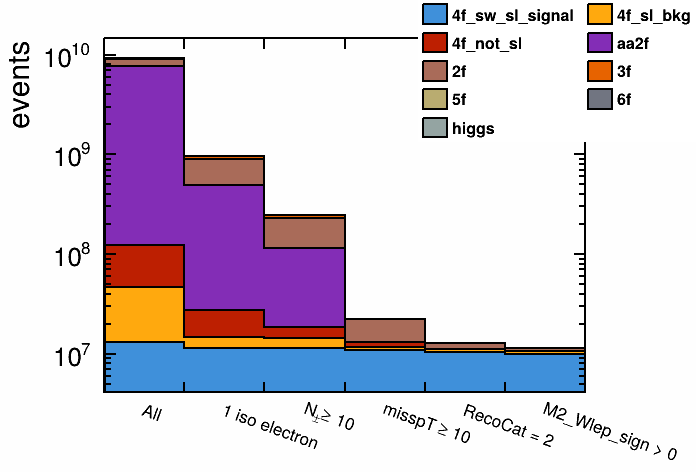

In [15]:
analysis.print_reports()
analysis.draw_cutflow(plot_dir=plot_dir)

(<cppyy.gbl.THStack object at 0x4798a690>,
 <cppyy.gbl.TCanvas object at 0x473ca2e0>)

Info in <TCanvas::Print>: pdf file plots/pre-selection/full/('n_isoelectrons', 5000, 0.0, 0.0).pdf has been created
Info in <TCanvas::Print>: pdf file plots/pre-selection/full/('n_charged_PFOs', 5000, 0.0, 0.0).pdf has been created
Info in <TCanvas::Print>: pdf file plots/pre-selection/full/('misspT', 5000, 0.0, 0.0).pdf has been created
Info in <TCanvas::Print>: pdf file plots/pre-selection/full/('RecoCatAdvanced', 5000, 0.0, 0.0).pdf has been created
Info in <TCanvas::Print>: pdf file plots/pre-selection/full/('M2_Wlep_sign', 5000, 0.0, 0.0).pdf has been created


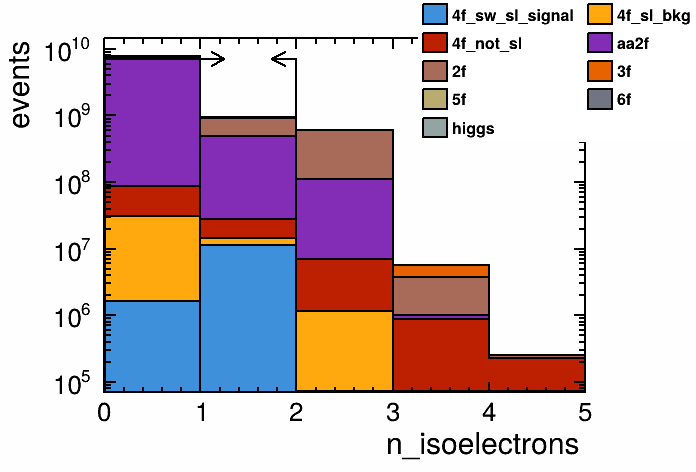

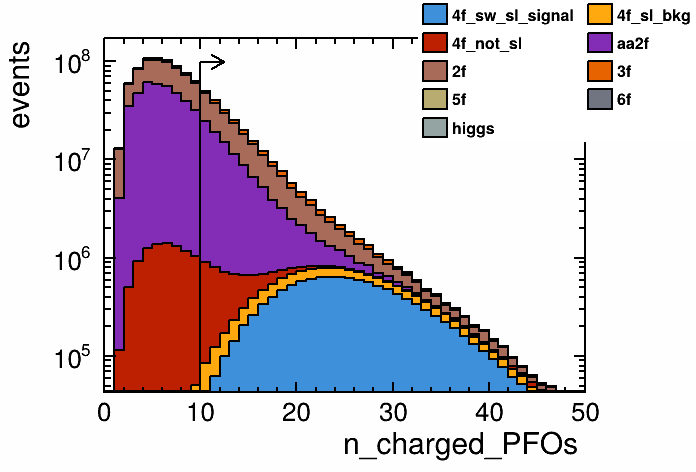

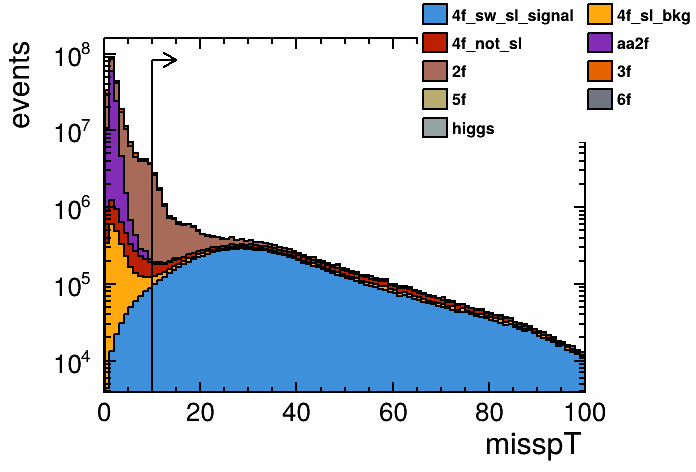

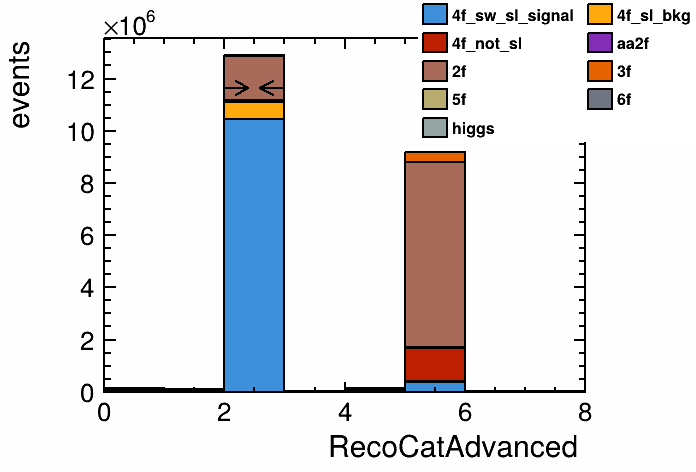

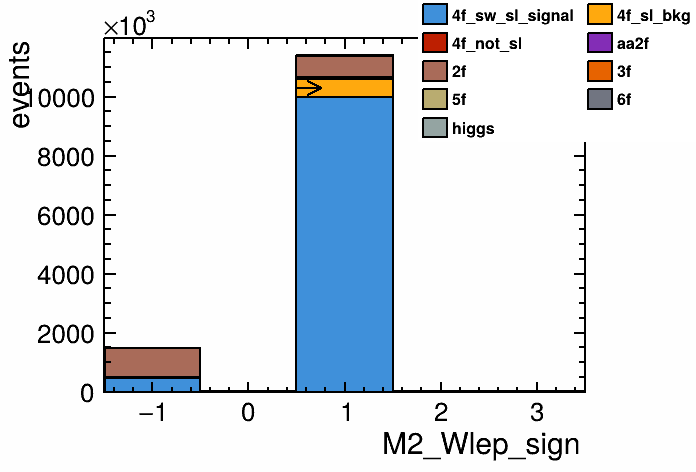

In [16]:
# unfortunately the jsroot plots break all the time, maybe it is just too much for them
# %jsroot on
# 0 - hadronic (both W decay hadronically)
# 1 - invisible semileptonic (one W decays hadronically, but the lepton is not within detector acceptance/detected)
# 2 - semileptonic electron
# 3 - semileptonic muon
# 4 - semileptonic tauon
# 5 - leptonic (both W decay leptonically)
# 6 - other, 7- broken?
# analysis.draw_histogram("RecoCatBasic")
analysis.draw_histogram("n_isoelectrons", logY=True, plot_dir=plot_dir, x_arrowl=1.0, x_arrowr=2.0)
analysis.draw_histogram("n_charged_PFOs", logY=True, plot_dir=plot_dir, x_arrowl=10.)
analysis.draw_histogram("misspT", logY=True, plot_dir=plot_dir, x_arrowl=10.)
analysis.draw_histogram("RecoCatAdvanced", plot_dir=plot_dir, x_arrowl=2., x_arrowr=3.)
analysis.draw_histogram("M2_Wlep_sign", plot_dir=plot_dir, x_arrowl=0.5)

(<cppyy.gbl.THStack object at 0x46df3630>,
 <cppyy.gbl.TCanvas object at 0x4831ae40>)

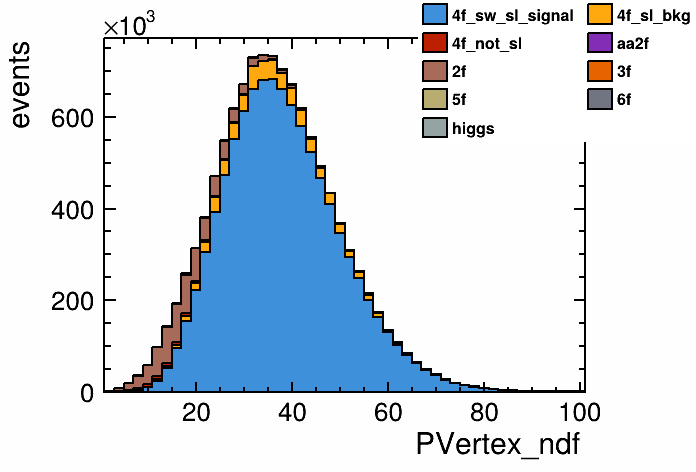

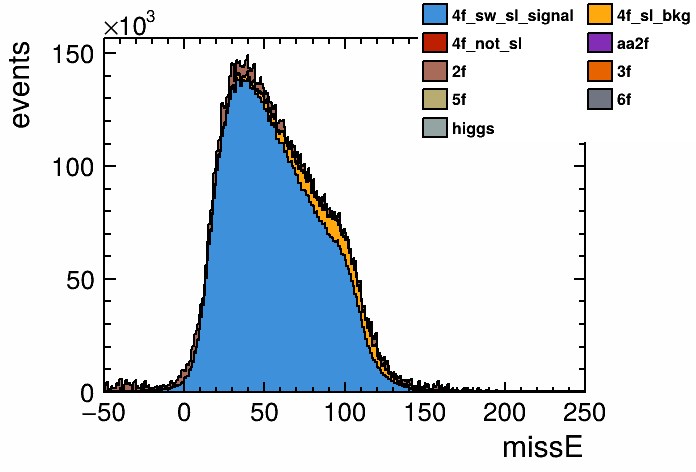

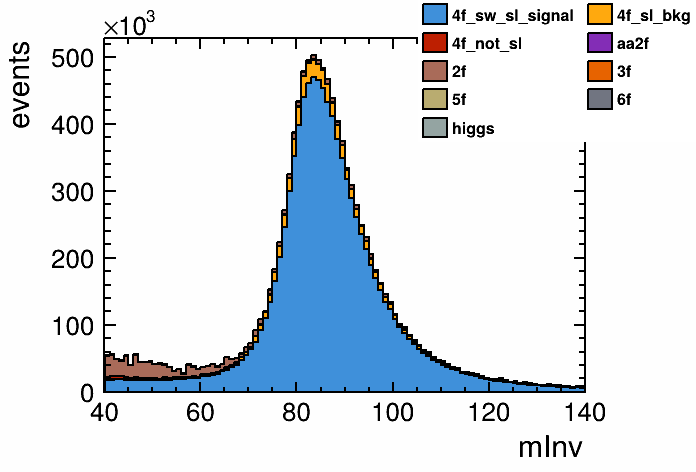

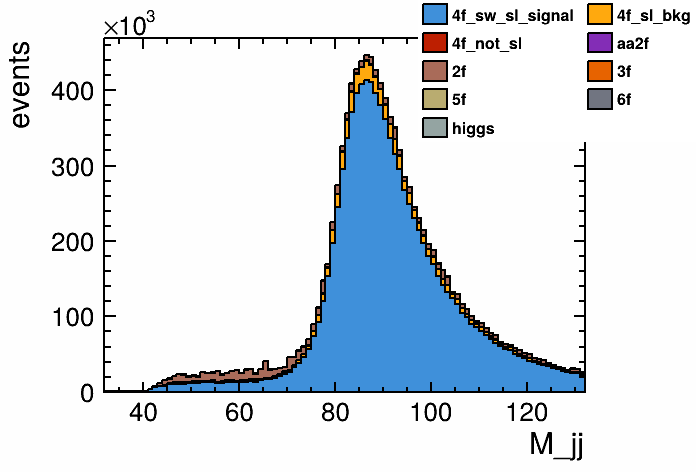

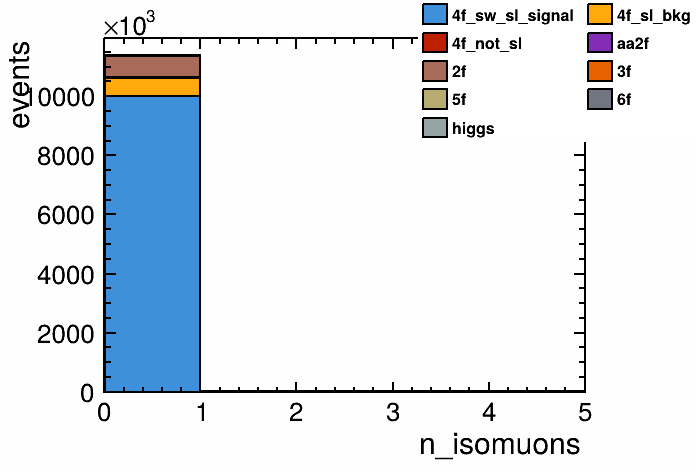

In [17]:
analysis.draw_histogram("PVertex_ndf")

analysis.draw_histogram("missE")
analysis.draw_histogram("mInv")
analysis.draw_histogram("M_jj")
analysis.draw_histogram("n_isomuons")

(<cppyy.gbl.THStack object at 0x48ad5e80>,
 <cppyy.gbl.TCanvas object at 0x47825840>)

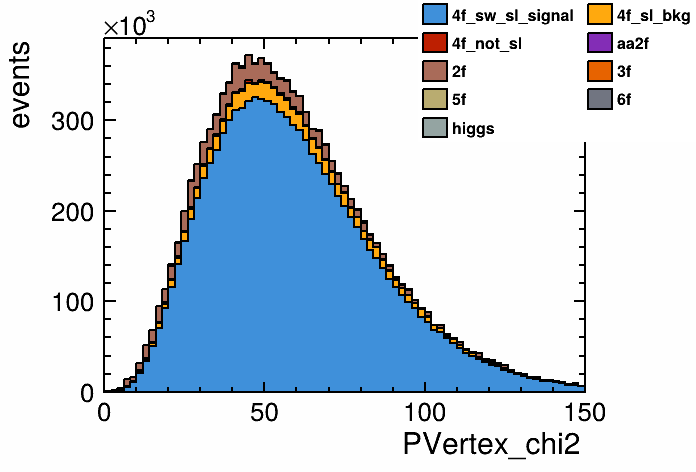

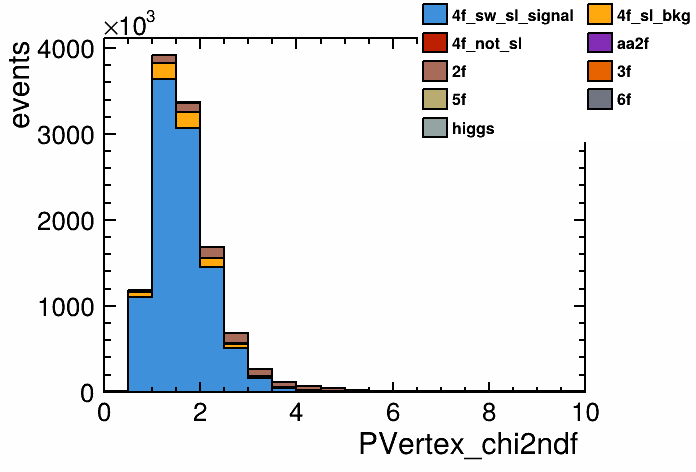

In [18]:
analysis.draw_histogram("PVertex_chi2")
analysis.draw_histogram("PVertex_chi2ndf")